In [10]:
import sys
import numpy as np
import h5py

oneGB_complex = 64 * 1024**2

In [6]:
def h5py_File_with_cache(name, mode='a', chunk_cache_mem_size=1024**2, w0=0.75, n_cache_chunks=2, **kwds):
    """Create h5py File object with cache specification
    
    This function is basically just a wrapper around the usual h5py.File constructor,
    but accepts two additional keywords:
    
    Parameters
    ----------
    [various]
        Standard h5py.File arguments
    chunk_cache_mem_size : int
        Number of bytes to use for the chunk cache.  Defaults to 1024**2 (1MB), which
        is also the default for h5py.File -- though it cannot be changed through the
        standard interface.
    w0 : float between 0.0 and 1.0
        Eviction parameter.  Defaults to 0.75.  "If the application will access the
        same data more than once, w0 should be set closer to 0, and if the application
        does not, w0 should be set closer to 1."
          --- <https://www.hdfgroup.org/HDF5/doc/Advanced/Chunking/>
    n_cache_chunks : int
        Number of chunks to be kept in cache at a time.  Defaults to 2.  Make this
        whatever you need to work on at a time.
    
    """
    import sys
    import numpy as np
    import h5py
    name = name.encode(sys.getfilesystemencoding())
    open(name, mode).close()  # Just make sure the file exists
    if 'dtype' in kwds:
        bytes_per_object = np.dtype(kwds['dtype']).itemsize
    else:
        bytes_per_object = np.dtype(np.float).itemsize  # assume float as most likely
    nslots = 100 * n_cache_chunks
    propfaid = h5py.h5p.create(h5py.h5p.FILE_ACCESS)
    settings = list(propfaid.get_cache())
    settings[1:] = (nslots, chunk_cache_mem_size, w0)
    propfaid.set_cache(*settings)
    return h5py.File(h5py.h5f.open(name, fapl=propfaid), **kwds)


In [75]:
def transpose_hdf5(dset_in, file_name_out, dset_name_out, chunk_cache_mem_size=1024**3, w0=1.0,
                   R2=None, C2=None, close_file_when_done=False, access_axis=1):
    """Transpose large matrix in HDF5 for fast access on transposed row
    
    Assuming the input dataset is chunked along its column (second) index, this function
    transposes it to an output dataset that is chunked along its column index.  Done naively,
    this operation can be extraordinarily slow, because we need to access rows in the input
    in order to write columns in the output.  But row access is slow because the entire
    column chunk needs to be read.  A similar problem occurs for writing.
    
    This function splits the difference, using the chunk cache to maximum advantage.  Roughly
    speaking, if we have sufficient memory to store M elements, we can set the output chunk
    size to sqrt(M) and process sqrt(M) chunks at a time.
    
    The input dataset may actually be one-dimensional, but interpreted as a matrix of shape
    R1xC1 = C2xR2.  Or the input may simply be a matrix of that shape, in which case R2 and
    C2 will be inferred.
    
    
    Parameters
    ----------
    dset_in : h5py.Dataset
        Open dataset in an h5py File object used as input.
    
    file_name_out : str
    dset_name_out : str
        Names of file and dataset in that file used for output.
    
    chunk_cache_mem_size : int
    w0 : float
        Parameters passed to `h5py_File_with_cache`.  See that function's documentation.
    
    R2, C2 : int
        Number of rows and columns in returned dataset.  These default to None, in which case
        the shape is inferred from the shape of the input.  Note that if the input is 1-D,
        this could turn out badly because each row will have just one element, which will be
        slow.
    
    close_file_when_done : bool
        If True, close output file and return None.  If False, return file handle and dataset.
        Default is False.
        
    access_axis : int
        Axis along which the output array will be accessed.  Default is 1, meaning the second
        (column) index.  Anything else will be interpreted as 0.
    
    
    """
    import numpy as np
    import h5py
    
    # Figure out the basic output sizes
    if R2 is None:
        if len(dset_in.shape)>1:
            R2 = dset_in.shape[1]
        else:
            R2 = 1
    if C2 is None:
        C2 = dset_in.shape[0]

    bytes_per_object = np.dtype(dset_in.dtype).itemsize
    num_chunk_elements = chunk_cache_mem_size // bytes_per_object
    sqrt_n_c_e = int(np.sqrt(num_chunk_elements))
    
    assert R2*C2 == dset_in.size, "Requested size {0}*{1}={2} is incompatible with input size {3}".format(R2, C2, R2*C2, dset_in.size)
    
    # If the transposition can be done in memory, just do it
    if dset_in.size <= num_chunk_elements:
        print("Doing transpose in memory")
        file_out = h5py.File(file_name_out, 'a')
        if dset_name_out in file_out:
            del file_out[dset_name_out]
        dset_out = file_out.create_dataset(dset_name_out, shape=(R2, C2), dtype=dset_in.dtype)
        dset_out[:] = dset_in[:].reshape(C2, R2).T
        
    else:

        # Set up output file and dset
        if access_axis == 1:
            n_cache_chunks = min(sqrt_n_c_e, R2)
            chunk_size = min(num_chunk_elements//n_cache_chunks, C2)
            chunks = (1, chunk_size)
        else:
            n_cache_chunks = min(sqrt_n_c_e, C2)
            chunk_size = min(num_chunk_elements//n_cache_chunks, R2)
            chunks = (chunk_size, 1)
        file_out = h5py_File_with_cache(file_name_out, 'a', chunk_cache_mem_size, w0, n_cache_chunks)
        if dset_name_out in file_out:
            del file_out[dset_name_out]
        dset_out = file_out.create_dataset(dset_name_out, shape=(R2, C2), dtype=x.dtype, chunks=chunks)

        # Depending on whether input is 1-D or 2-D, we do this differently
        if len(dset_in.shape)==1:
            def submatrix_dset_in(r2a, r2b, c2a, c2b):
                temp = np.empty((c2b-c2a, r2b-r2a), dtype=dset_in.dtype)
                C1 = R2
                c1a, c1b = r2a, r2b
                for r1 in range(c2a, c2b):
                    try:
                        temp[r1-c2a] = dset_in[r1*C1+c1a:r1*C1+c1b]
                    except ValueError:
                        print(r2a, r2b, "\t", c2a, c2b, "\n", r1, c1a, c1b, "\t", C1)
                        print(r1-c2a, r1*C1+c1a, r1*C1+c1b, dset_in.shape, temp.shape)
                        raise
                return temp
        else:
            def submatrix_dset_in(r2a, r2b, c2a, c2b):
                return dset_in[c2a:c2b, r2a:r2b]

        # Do the transposition
        for c2a in range(0, C2, chunk_size):
            for r2a in range(0, R2, n_cache_chunks):
                c2b = min(C2, c2a+chunk_size)
                r2b = min(R2, r2a+n_cache_chunks)
                dset_out[r2a:r2b, c2a:c2b] = submatrix_dset_in(r2a, r2b, c2a, c2b).T

    if close_file_when_done:
        file_out.close()
        return
    else:
        return file_out, dset_out

In [112]:
# Write a test file

np.random.seed(1234)
N = oneGB_complex * 2
N_creation = min(16*1024**2, N)
print("Creating test data of {0} points".format(N)); sys.stdout.flush()
# %tic Just random numbers
# for k in range(0, N, N_creation):
#     size = min(N-k, N_creation)
#     tmp = np.random.random(size) + 1j*np.random.random(size)
# %toc
%tic Generating and writing
with h5py.File('/Users/boyle/Research/Temp/test_in.h5', 'w') as f:
    x = f.create_dataset('x', shape=(N,), dtype=complex)
    N_creation = 16*1024**2
    for k in range(0, N, N_creation):
        size = min(N-k, N_creation)
        x[k:k+size] = np.random.random(size) + 1j*np.random.random(size)
%toc
print("Finished writing test data to file")

Creating test data of 134217728 points
          Generating and writing:   8.83 s
Finished writing test data to file


In [115]:
# %%prun

# Profiling with the above line shows that the main time-wasters for large N are dataset.__getitem__ and dataset.__setitem__
# This is not a surprise, of course.  The question is whether or not it's possible to do much better with better chunking, etc.
# I suspect I can't do too much better since timing the cell above suggests that it takes about one fourth as much time just
# to write data to the file.  So between reading and writing, and constructing the file

! /bin/rm -f /Users/boyle/Research/Temp/test_transpose.h5

with h5py.File('/Users/boyle/Research/Temp/test_in.h5', 'r') as f:
    x = f['x']
    R2, C2 = N//1024, 1024
    %tic
    f2, d = transpose_hdf5(x, '/Users/boyle/Research/Temp/test_transpose.h5', 'x', R2=R2, C2=C2, chunk_cache_mem_size=1024**3)
    %toc
    if x.size <= oneGB_complex//2:
        print(np.array_equal(x[:].reshape(C2, R2).T, d[:]))
    f2.close()

with h5py.File('/Users/boyle/Research/Temp/test_transpose.h5', 'r') as f:
    x = f['x']
    %tic
    f2, d = transpose_hdf5(x, '/Users/boyle/Research/Temp/test_transpose2.h5', 'x', chunk_cache_mem_size=1024**3)
    %toc
    if x.size <= oneGB_complex//2:
        print(np.array_equal(x[:].T, d[:]))
    else:
        print(np.all([np.array_equal(x[c2a:c2b, r2a:r2b].T, d[r2a:r2b, c2a:c2b])
                      for r2a in range(0, R2, min(R2, C2)) for r2b in [min(R2, r2a+min(R2, C2))]
                      for c2a in range(0, C2, min(R2, C2)) for c2b in []]))
    f2.close()
    
! ls -lah /Users/boyle/Research/Temp/test_in.h5 /Users/boyle/Research/Temp/test_transpose.h5 /Users/boyle/Research/Temp/test_transpose2.h5
! h5ls /Users/boyle/Research/Temp/test_transpose.h5
! h5ls /Users/boyle/Research/Temp/test_transpose2.h5
! /bin/rm -f /Users/boyle/Research/Temp/test_transpose.h5
! /bin/rm -f /Users/boyle/Research/Temp/test_transpose2.h5

            9.99 s
            9.33 s
True
-rw-r--r--+ 1 boyle  staff   2.0G Jan 25 12:44 /Users/boyle/Research/Temp/test_in.h5
-rw-r--r--+ 1 boyle  staff   2.0G Jan 25 12:53 /Users/boyle/Research/Temp/test_transpose.h5
-rw-r--r--+ 1 boyle  staff   2.0G Jan 25 12:53 /Users/boyle/Research/Temp/test_transpose2.h5
x                        Dataset {131072, 1024}
x                        Dataset {1024, 131072}


In [102]:
times = {
    oneGB_complex//64: 0.387,
    oneGB_complex//32: 0.792,
    oneGB_complex//16: 1.73,
    oneGB_complex//8 : 4.03,
    oneGB_complex//4 : 6.76,
    oneGB_complex//2 : 13.5,
    oneGB_complex    : 29.4,
    2*oneGB_complex  : 63.0,
    4*oneGB_complex  : 314.0,
    8*oneGB_complex  : 782.0,
    #16*oneGB_complex : 0,
}

times2 = {
    oneGB_complex//64: 0.0461,
    oneGB_complex//32: 0.104,
    oneGB_complex//16: 0.219,
    oneGB_complex//8 : 0.405,
    oneGB_complex//4 : 0.902,
    oneGB_complex//2 : 1.96,
    oneGB_complex    : 3.94,
    2*oneGB_complex  : 8.41,
    4*oneGB_complex  : 31.1,
    8*oneGB_complex  : 85.0,
    16*oneGB_complex : 209.0,
}

In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

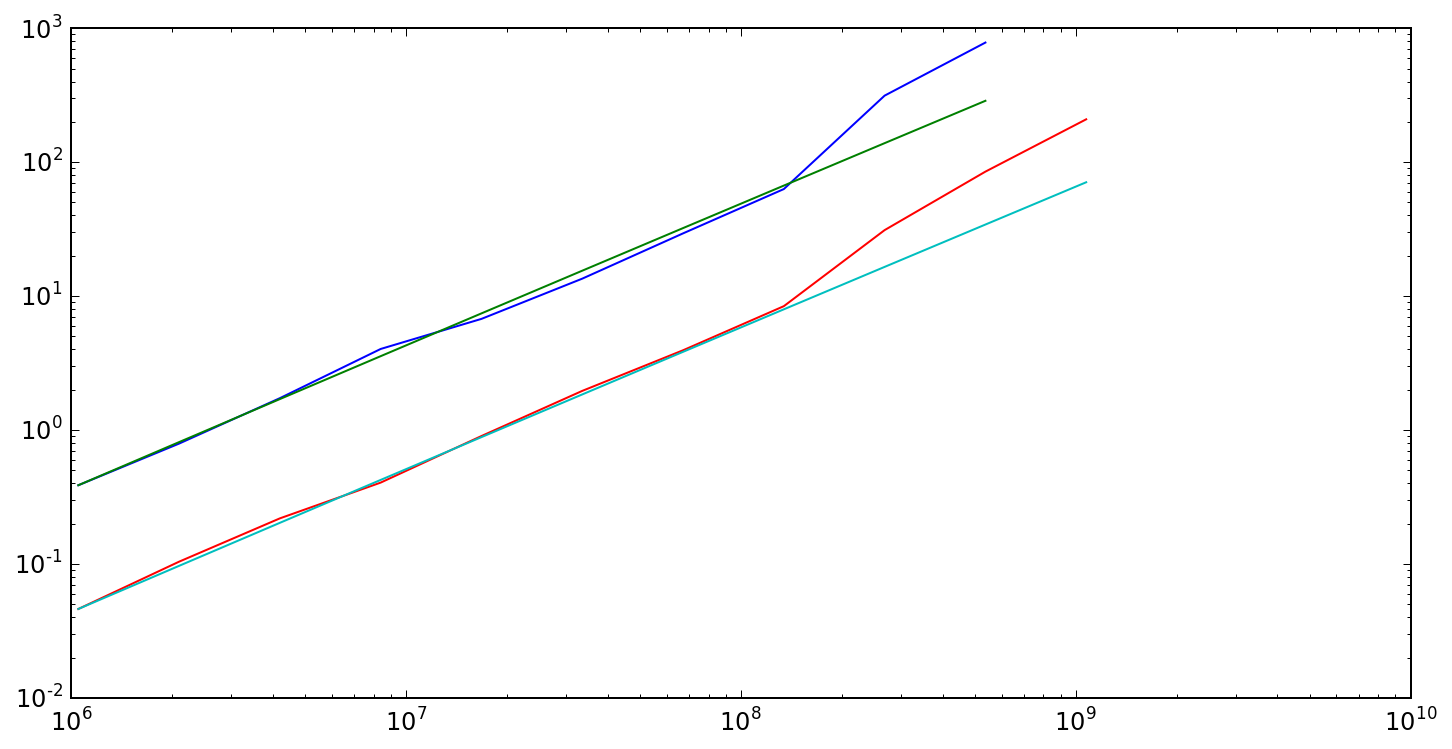

In [103]:
def scaling(size):
    return size*np.log2(size)
sizes = np.array(sorted(times.keys()))
timings = np.array(sorted(times.values()))
plt.loglog(sizes, timings)
plt.loglog(sizes, scaling(sizes)*(timings[0]/scaling(sizes[0])))
sizes = np.array(sorted(times2.keys()))
timings = np.array(sorted(times2.values()))
plt.loglog(sizes, timings)
plt.loglog(sizes, scaling(sizes)*(timings[0]/scaling(sizes[0])))